In [1]:
import os

def get_repo_dir():
    cwd = os.getcwd()
    splited = cwd.split('/')
    ind = splited.index('fsCounter')
    repo_dir = '/'
    for s in splited[1:ind + 1]:
        repo_dir = os.path.join(repo_dir, s)

    return repo_dir

In [2]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display



sys.path.append(get_repo_dir())

from vision.tools.jupyter_notebooks.notebook_analysis_help_funcs import *
from vision.tools.post_process_analysis import read_tracks_and_slices, get_block_count
from vision.visualization.draw_bb_from_csv import draw_tree_bb_from_tracks

In [3]:
def concat_to_meta(block_meta, df):
    df_col = list(block_meta.columns)
    df['block'] = df['block'].str.lower()
    new_data = []
    data = block_meta.copy()
    for id_, sample in data.iterrows():
        block = sample['block'].lower()
        row = sample['row'].lower()
        tree_id = int(sample['tree_id'])
        q_data = df.query(f'block == "{block}" and row == "{row}" and tree_id == {tree_id}')
        new_sample = sample.to_list()
        for i in range(1, 4):
            new_sample.append(q_data[str(i)].values[0])
        new_data.append(new_sample)

    df_col += ['cv1', 'cv2', 'cv3']
    new_df = pd.DataFrame(new_data, columns=df_col)

    return new_df

def add_ratios(df):
    df['F/cv1'] = df['F'] / df['cv1']
    df['F/cv2'] = df['F'] / df['cv2']
    df['F/cv3'] = df['F'] / df['cv3']

    return df

def get_block_ratio(block_df, row_tracks, y_threshold=800, depth=3):
    block_col = list(block_df.columns)
    new_data = []
    for id_, sample in block_df.iterrows():
        row = sample['row'].lower()
        tree_id = int(sample['tree_id'])
        tree_df = row_tracks[row][tree_id]

        d_tree_df = tree_df.query(f'depth <= {depth}')
        
        
        lower_tree_df = tree_df.query(f'y1 > {y_threshold} and depth <= {depth}')
        count = len(tree_df.track_id.unique())
        lower_count = len(lower_tree_df.track_id.unique())
        ratio = lower_count / count

        gdf = lower_tree_df.groupby('track_id')
        lower_tracks_depth = np.array(gdf.depth.mean())
        filtered_lower_tracks_depth = lower_tracks_depth[lower_tracks_depth < 3]
        mean = np.mean(filtered_lower_tracks_depth)
        std = np.std(filtered_lower_tracks_depth)          
        
        new_sample = sample.to_list()
 
        uniq, counts = np.unique(d_tree_df["track_id"], return_counts=True)
        for i in range(0, 5):
            new_sample.append(len(uniq[counts>i]))
            
        new_data.append(new_sample)

    #block_col += ['y_ratio', 'mean', 'std', 'lcv1', 'lcv2', 'lcv3', 'lcv4', 'lcv5']
    block_col += ['dcv1', 'dcv2', 'dcv3', 'dcv4', 'dcv5']
    new_df = pd.DataFrame(new_data, columns=block_col)

    return new_df    

In [4]:
def linear_model_selection(data, selection_cols=["cv1"], type_col="block", cross_val='row'):

    factors = {}
    for col in selection_cols:
        factor, res_mean, res_std, tree_mean, tree_std, all_preds = run_LROCV(data, cv_col=col, type_col=type_col, cross_val=cross_val, return_res=True)
        factors[col] = {'factor': factor, 'mean_error': res_mean, 'std_error': res_std}

    return factors
    

In [5]:
def block_analysis(block_path, metadata_path, block_):
    block_counts, row_tracks = get_block_count(block_path)
    block_counts_df = pd.DataFrame(block_counts, columns=['tree_id', 'block', 'row', '1', '2','3'])
    meta_data = pd.read_csv(metadata_path)
    block_meta = meta_data.query(f'block == "{block_}"')
    block_df = concat_to_meta(block_meta, block_counts_df)
    block_df['F/cv1'] = block_df['F'] / block_df['cv1'] 
    block_df = get_block_ratio(block_df, row_tracks)

    return block_df, row_tracks

In [6]:
def get_selection_error(factors_dict, block_df):
    results = {}
    for item_ in list(factors_dict.keys()):
        block_df[f'err_{item_}'] = (block_df['F'] - (block_df[item_] * factors_dict[item_]['factor'])) / block_df['F']
        results[item_] = {'err': np.mean(block_df[f'err_{item_}']), 'err_std': np.std(block_df[f'err_{item_}'])}

    return results, block_df

In [7]:
metadata_path = "/media/matans/My Book/FruitSpec/Apples_SA/data_meta.csv"

In [8]:
block_path = "/media/matans/My Book/FruitSpec/Apples_SA/block_13"
block_ = 'Block_13'
block_13_df, row_tracks_13 = block_analysis(block_path, metadata_path, block_)

In [9]:
block_13_df

,id,block,row,tree,side,tree_id,variety,Age,F,cv1,cv2,cv3,F/cv1,dcv1,dcv2,dcv3,dcv4,dcv5
0,1,Block_13,Row_1111,9,A,2,Royal Beauty,7,823,973,518,364,0.845838,847,455,308,205,149
1,2,Block_13,Row_1111,10,A,1,Royal Beauty,7,1007,739,425,290,1.362652,696,390,273,209,160
2,3,Block_13,Row_2222,9,B,1,Royal Beauty,7,823,965,488,298,0.852850,822,425,249,172,104
3,4,Block_13,Row_2222,10,B,2,Royal Beauty,7,1007,1047,519,343,0.961796,989,483,315,198,142
4,5,Block_13,Row_3333,11,B,1,Royal Beauty,7,455,586,229,128,0.776451,508,196,105,73,53
5,6,Block_13,Row_3333,12,B,2,Royal Beauty,7,637,780,413,285,0.816667,712,390,271,201,159
6,7,Block_13,Row_4444,12,A,1,Royal Beauty,7,637,937,500,357,0.679829,821,435,309,236,167
7,8,Block_13,Row_4444,11,A,2,Royal Beauty,7,455,511,247,171,0.890411,439,215,142,111,77
8,9,Block_13,Row_5555,14,A,1,Early_red_one,7,1008,1159,799,648,0.869715,1096,745,595,454,366
9,10,Block_13,Row_5555,13,A,2,Early_red_one,7,1440,1814,1199,960,0.793826,1729,1150,908,720,585


In [ ]:
#row_to_drow = 'row_8888'
#tree_id = 2
draw_tree_bb_from_tracks(row_tracks[row_to_drow][tree_id], os.path.join(block_path, row_to_drow, '1'), tree_id)

Text(0, 0.5, 'F/CV1')

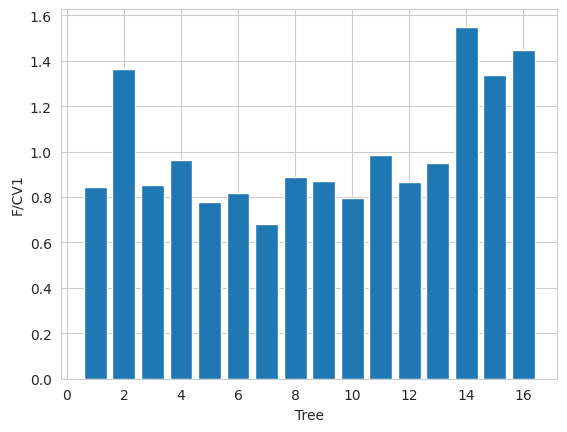

In [10]:
plt.bar(block_13_df['id'], block_13_df['F/cv1'])
plt.xlabel('Tree')
plt.ylabel('F/CV1')

/home/matans/miniconda3/envs/fsCounter/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x600 with 0 Axes>

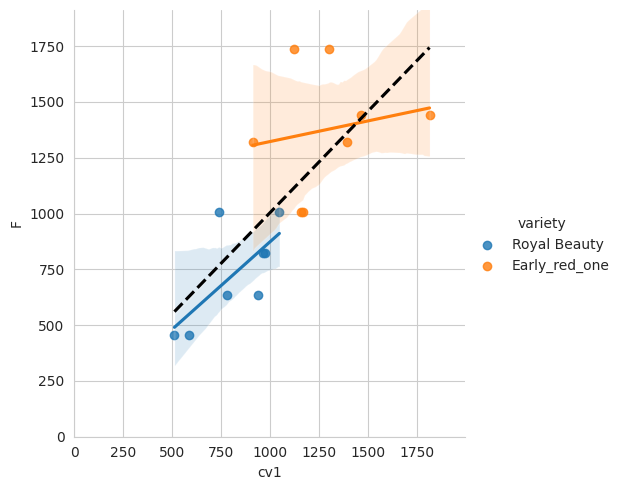

In [11]:
plot_F_cv(block_13_df, 1, hue='variety', add_xy_line=False)

/home/matans/miniconda3/envs/fsCounter/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x600 with 0 Axes>

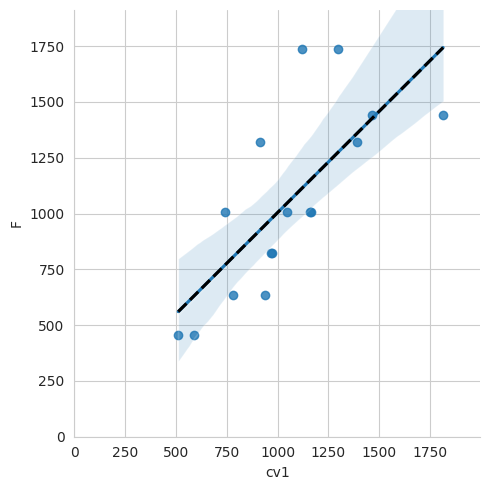

In [12]:
plot_F_cv(block_13_df, 1, add_xy_line=False)

In [13]:
factors_13_dict = linear_model_selection(block_13_df, selection_cols=['cv1','dcv1', 'cv3', 'dcv3'],type_col="block", cross_val='id')

true: 1319,    pred: 884.8299041168156. (32.92 %) (16)
true: 1738,    pred: 1244.3508042109831. (28.40 %) (15)
true: 1738,    pred: 1068.331464230948. (38.53 %) (14)
true: 1319,    pred: 1385.9840912846516. (5.08 %) (13)
true: 1008,    pred: 1167.3469071142258. (15.81 %) (12)
true: 1440,    pred: 1453.1588131143185. (0.91 %) (11)
true: 1440,    pred: 1871.8096729988156. (29.99 %) (10)
true: 1008,    pred: 1159.7476504849442. (15.05 %) (9)
true: 455,    pred: 507.4134465515467. (11.52 %) (8)
true: 637,    pred: 942.9406323486259. (48.03 %) (7)
true: 637,    pred: 777.8566473303844. (22.11 %) (6)
true: 455,    pred: 583.3457786847715. (28.21 %) (5)
true: 1007,    pred: 1040.0736246670854. (3.28 %) (4)
true: 823,    pred: 963.6300411258026. (17.09 %) (3)
true: 1007,    pred: 724.8759261213158. (28.02 %) (2)
true: 823,    pred: 972.0864825707442. (18.12 %) (1)
0.2144148458256939 0.12652466227636172
(0.2144148458256939, 0.12652466227636172)
[0.99160457]
true: 1319,    pred: 884.829904116815

In [14]:
res, block_13_df = get_selection_error(factors_13_dict, block_13_df)
res

{'cv1': {'err': -0.058683140897378826, 'err_std': 0.23056682084845417},
 'dcv1': {'err': -0.04043513662154898, 'err_std': 0.22337880718198241},
 'cv3': {'err': 0.09152695602663627, 'err_std': 0.261225990528413},
 'dcv3': {'err': 0.11089317266289973, 'err_std': 0.26639218525919206}}

In [15]:
block_13_df

,id,block,row,tree,side,tree_id,variety,Age,F,cv1,...,F/cv1,dcv1,dcv2,dcv3,dcv4,dcv5,err_cv1,err_dcv1,err_cv3,err_dcv3
0,1,Block_13,Row_1111,9,A,2,Royal Beauty,7,823,973,...,0.845838,847,455,308,205,149,-0.181150,-0.125666,0.111295,0.175764
1,2,Block_13,Row_1111,10,A,1,Royal Beauty,7,1007,739,...,1.362652,696,390,273,209,160,0.266826,0.244028,0.421339,0.402918
2,3,Block_13,Row_2222,9,B,1,Royal Beauty,7,823,965,...,0.852850,822,425,249,172,104,-0.171439,-0.092441,0.272434,0.333653
3,4,Block_13,Row_2222,10,B,2,Royal Beauty,7,1007,1047,...,0.961796,989,483,315,198,142,-0.038746,-0.074219,0.315583,0.311059
4,5,Block_13,Row_3333,11,B,1,Royal Beauty,7,455,586,...,0.776451,508,196,105,73,53,-0.286703,-0.221176,0.434732,0.491749
5,6,Block_13,Row_3333,12,B,2,Royal Beauty,7,637,780,...,0.816667,712,390,271,201,159,-0.223340,-0.222550,0.100997,0.063020
6,7,Block_13,Row_4444,12,A,1,Royal Beauty,7,637,937,...,0.679829,821,435,309,236,167,-0.469577,-0.409710,-0.126120,-0.068365
7,8,Block_13,Row_4444,11,A,2,Royal Beauty,7,455,511,...,0.890411,439,215,142,111,77,-0.122023,-0.055308,0.244837,0.312650
8,9,Block_13,Row_5555,14,A,1,Early_red_one,7,1008,1159,...,0.869715,1096,745,595,454,366,-0.148722,-0.189258,-0.291726,-0.300041
9,10,Block_13,Row_5555,13,A,2,Early_red_one,7,1440,1814,...,0.793826,1729,1150,908,720,585,-0.258540,-0.313284,-0.339567,-0.388750


In [16]:
factors_13_dict


{'cv1': {'factor': array([0.99906113]),
  'mean_error': 0.2144148458256939,
  'std_error': 0.12652466227636172},
 'dcv1': {'factor': array([1.09377003]),
  'mean_error': 0.2033347454571638,
  'std_error': 0.13099617953690934},
 'cv3': {'factor': array([2.00935114]),
  'mean_error': 0.2741728118169738,
  'std_error': 0.11133312408455796},
 'dcv3': {'factor': array([2.20242271]),
  'mean_error': 0.27965816642227304,
  'std_error': 0.13109718983244406}}

In [ ]:
block_21_path = "/media/matans/My Book/FruitSpec/Apples_SA/block_21"
block_21 = 'Block_21'
block_21_df, row_tracks_21 = block_analysis(block_21_path, metadata_path, block_21)

In [ ]:
block_21_df

In [ ]:
plot_F_cv(block_21_df, 1, add_xy_line=False)

In [ ]:
factors_21_dict = linear_model_selection(block_21_df, selection_cols=['cv1','dcv1', 'cv3', 'dcv3'],type_col="block", cross_val='id')

In [ ]:
res, block_block_21_df13_df = get_selection_error(factors_21_dict, block_21_df)
res

In [ ]:
#row_to_drow = 'row_1111'
#tree_id = 1
#draw_tree_bb_from_tracks(row_tracks[row_to_drow][tree_id], os.path.join(block_path, row_to_drow, '1'), tree_id)

In [ ]:
plt.bar(block_21_df['id'], block_21_df['F/cv1'])
plt.xlabel('Tree')
plt.ylabel('F/CV1')

In [ ]:
block_48_path = "/media/matans/My Book/FruitSpec/Apples_SA/block_48"
block_48 = 'Block_48'
block_48_df, row_tracks_48 = block_analysis(block_48_path, metadata_path, block_48)

In [ ]:
block_48_df

In [ ]:
factors_48_dict = linear_model_selection(block_48_df, selection_cols=['cv1','dcv1', 'cv3', 'dcv3'],type_col="block", cross_val='id')

In [ ]:
res, block_48_df_res = get_selection_error(factors_48_dict, block_48_df)
res

In [ ]:
plt.bar(block_48_df['id'], block_48_df['F/cv1'])
plt.xlabel('Tree')
plt.ylabel('F/CV1')

In [ ]:
block_3_path = "/media/matans/My Book/FruitSpec/Apples_SA/block_3"
block_3 = 'Block_3'
block_3_df, row_tracks_3 = block_analysis(block_3_path, metadata_path, block_3)

In [ ]:
block_3_df

In [ ]:
factors_3_dict = linear_model_selection(block_3_df, selection_cols=['cv1','dcv1', 'cv3', 'dcv3'],type_col="block", cross_val='id')

In [ ]:
plt.bar(block_3_df['id'], block_3_df['F/cv1'])
plt.xlabel('Tree')
plt.ylabel('F/CV1')

In [ ]:
res, block_3_df_res = get_selection_error(factors_3_dict, block_3_df)

In [ ]:
res

In [ ]:
block_3_df_res

In [17]:
block_83_path = "/media/matans/My Book/FruitSpec/Apples_SA/083GOLD0"
block_83 = '083GOLD0'
block_83_df, row_tracks_83 = block_analysis(block_83_path, metadata_path, block_83)

In [18]:
block_83_df

,id,block,row,tree,side,tree_id,variety,Age,F,cv1,cv2,cv3,F/cv1,dcv1,dcv2,dcv3,dcv4,dcv5
0,73,083GOLD0,Row_111,1,A,1,Golden Delicious,7,926,595,354,285,1.556303,574,340,264,198,157
1,74,083GOLD0,Row_111,2,A,2,Golden Delicious,7,978,79,32,0,12.379747,69,25,0,0,0
2,75,083GOLD0,Row_222,2,B,1,Golden Delicious,7,978,686,413,309,1.425656,650,391,288,198,159
3,76,083GOLD0,Row_222,1,B,2,Golden Delicious,7,926,590,349,256,1.569492,555,324,223,169,133
4,77,083GOLD0,Row_333,3,A,1,Golden Delicious,7,1263,510,323,244,2.476471,483,298,218,158,120
5,78,083GOLD0,Row_333,4,A,2,Golden Delicious,7,1224,488,255,144,2.508197,458,223,119,64,39
6,79,083GOLD0,Row_444,4,B,1,Golden Delicious,7,1224,973,542,400,1.257965,905,500,346,236,176
7,80,083GOLD0,Row_444,3,B,2,Golden Delicious,7,1263,628,369,284,2.011146,586,336,263,197,159


In [ ]:
block_20_path = "/media/matans/My Book/FruitSpec/Apples_SA/020GRANO"
block_20 = '020GRANO'
block_20_df, row_tracks_20 = block_analysis(block_20_path, metadata_path, block_20)

In [ ]:
block_20_df